# CA2 - Data Preparation and Visualization on Agriculture Datasets

## 1. Overview

The following agriculture datasets were pre-processed to be used by the Machine Learning (ML), Statistics and DataPrepVisDashboard Jupyter notebooks.

- Organic Farming Area
- Crops and Livestock Products Import/Export
- Food Price Inflation
- Tweets Dataset

## 2. Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [1]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *
from twitter_api import *

# uncomment to install any missing lib
# !pip install python-dotenv
# !pip install wordcloud

# importing modules specific to this notebook
import logging
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from wordcloud import WordCloud
from dotenv import dotenv_values
from nltk.probability import FreqDist

# use a logger to help debugging
logger = logging.getLogger('data_prep_vis')

# set logger level
logger.setLevel(logging.ERROR)

def convert_to_number(df, col_list=[]):
    """
    This function converts the column in the list into
    numeric data type.

    Parameters:
        df: Data frame with original data.
        col_list: List of column names to be converted.
    Return:
        Updated dataframe.
    """         
    for c in col_list:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def get_env_map():
    """
    Auxiliary function to read and parse the environment file for the Twitter API.
    
    It assumes an env file exists in the home dir.

    Returns:
        env (dict): Dictionary with the env parameters.
    """
    env_path = join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def process_tweets(tweets_list):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for i in range(0, len(tweets_list)):
        # raw tweet
        tweet_raw = tweets_list[i]
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        # strip tweet
        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)
        
        # cleaned tweet
        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        # steemed tweet
        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        # lemmatized tweet
        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def get_collected_twitter_file_path():
    """
    Auxiliary function to get a valid twitter file name.
    
    It checks if there is a file with the same name and append an index.

    Returns:
        filename (str): Available filename.
    """    
    same_file_list = [f for f in listdir(TWEETS_DIR) if isfile(join(TWEETS_DIR, f)) 
                      and str(f).startswith(TWEETS_DF_FILE) and str(f).endswith('.csv')]
    n_same_file = len(same_file_list)

    suffix = ''
    if n_same_file > 0:
        suffix = f'_{ n_same_file }'

    filename = f'{TWEETS_DF_FILE}{ suffix }.csv'
    return join(TWEETS_DIR, filename)

def get_freq(df, colname):
    '''
    Auxiliary function to calculate the frequency distribution of the words in a column.

    Parameters:
        df (DataFrame): Data frame to be processed.
        colname  (str): Column name to get its frequency calculated.
    Returns:
        fdist    (mtx): Frequency distribution of the tokens.
    '''
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor.get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    wordcloud.to_file(join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## 3. Organic Farming Area

In this section, the organic farming dataset was cleand and prepared for the analysis performed in the Statistics Jupyter notebook.

This dataset stores the percent of land under organic farming per country over the years.

There are data about 34 European countries from 2000 until 2020, as shown below.

In [2]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, ORG_FARM_DATASET), encoding='utf-8')
dataset.head()

,GEO (Codes),GEO (Labels),2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,EU,"European Union (EU6-1958, EU9-1973, EU10-1981,...",3.0,:,3.8,4.0,:,3.8,4.1,4.0,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,EU27_2020,European Union - 27 countries (from 2020),:,:,:,:,:,:,:,:,...,:,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,EU28,European Union - 28 countries (2013-2020),:,:,:,:,:,:,:,:,...,:,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,:
3,BE,Belgium,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,BG,Bulgaria,:,:,:,:,:,0.2,0.1,0.3,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


The raw dataset was cleaned to remove unnecessary columns and to convert the percent data into numeric data type. 

That step was necessary to fit the dataset into the functions used to calculate the confidence interval as part of the statistical analysis.

The main idea of the analysis performed about this dataset was to compare Ireland's organic farming growth with the estimated confidence interval for Europe.

This way, it was also created two datasets out of it, one with all 34 countries data and another one with Ireland's data only.

In [3]:
# number of countries available in this dataset
len(dataset.loc[~dataset['GEO (Codes)'].str.contains('EU')]['GEO (Codes)'].unique())

34

In [4]:
# keeping only specific countries data
codes_col = dataset.keys()[0]
dataset_all = dataset.loc[~dataset[codes_col].str.contains('EU')]

# getting Ireland's data only
dataset_ire = dataset.loc[dataset[codes_col] =='IE']

# removing first two columns with labels
dataset_all = dataset.iloc[:,2:]
dataset_ire = dataset_ire.iloc[:,2:]

# converting data into numbers
columns = dataset_all.keys()
dataset_all = convert_to_number(dataset_all, columns)
dataset_ire = convert_to_number(dataset_ire, columns)

In [5]:
# show dataset all head
dataset_all.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3.0,NaN,3.8,4.0,NaN,3.8,4.1,4.0,4.3,4.7,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,NaN
3,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,2.6,3.0,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,NaN,NaN,NaN,NaN,NaN,0.2,0.1,0.3,0.3,0.2,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


In [ ]:
# show dataset ireland head
dataset_ire.head()

The command below shows the dataset has null values spread all over the rows. 

Since each country has nulls in different rows they can't be simply removed at this point, so they should be handled properly in the analysis part.

In [11]:
# checking empty values on full dataset
pd.DataFrame(dataset_all.isnull().sum(), columns=['Null Values']).head()

,Null Values
2000,20
2001,21
2002,19
2003,16
2004,11


In [13]:
# checking empty values on ireland dataset
pd.DataFrame(dataset_ire.isnull().sum(), columns=['Null Values']).head()

,Null Values
2000,0
2001,0
2002,0
2003,0
2004,0


The cleaned datasets were stored in the output folder to be used by other notebooks.

In [14]:
# creating a csv file in the output folder for the full dataset
dataset_all.to_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET), index=False)

# creating a csv file in the output folder for the irish dataset
dataset_ire.to_csv(join(DATA_PREP_FOLDER, ORG_FARM_DATASET_IRE), index=False)

## 4. Crops and Livestock Products Import/Export

In this section, the crops and livestock products import and export datasets were cleand and prepared for the analysis performed in the Statistics and ML Jupyter notebooks.

This dataset stores import and export data of several agriculture products in Ireland, Finland and Slovakia.

In [15]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, IMP_EXP_DATASET), encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


The first step was the null check, which showed there is no null values in this dataset.

In [16]:
# checking empty values on full dataset
dataset.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

Now, the Value's column data were converted into numeric data type to comply with the Python functions used.

In [17]:
# converting Value column into numeric data type
dataset = convert_to_number(dataset, ['Value'])
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


The main idea of the analysis performed about this dataset was to compare the countries import/export data with Ireland.

Thus, the data was split into import/export quantity (data in tonnes) and import/export value (data in US$) datasets to facilitate data manipulation.

In [18]:
# checking the Element values
list(dataset['Element'].unique())

['Import Quantity', 'Import Value', 'Export Quantity', 'Export Value']

In [19]:
# splitting data into import/export value and quantity
im_ex_val_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]

After splitting the datasets, it was checked the Unit column so that data is compared against the same measurement unit.

In [20]:
# checking unit for import/export quantity data
print(im_ex_val_data['Unit'].unique())
print(im_ex_qtt_data['Unit'].unique())

['1000 US$']
['tonnes' 'Head' 'No' '1000 Head']


Import/Export value is measured in 1000 US$, so no need to change anything here. 

On the other hand, the Import/Export quantity data were collected using different units: ['tonnes' 'Head' 'No' '1000 Head'].

As shown in the command below, most of the rows is measured in Tonnes, so the other units were removed to avoid mixing up unrelated data.

In [21]:
im_ex_qtt_data['Unit'].describe()

count      97496
unique         4
top       tonnes
freq       94961
Name: Unit, dtype: object

In [22]:
# since tonnes is the most frequent unit, remove the other ones
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

As shown below, Slovakia data covers a period of time between 1993 and 2020, while Finland and Ireland have data starting from 1961.

This fact about the dataset should also be taken into account during the analysis part.

In [23]:
# date range for Slovakia dataset
print(im_ex_qtt_data[im_ex_qtt_data['Area']=='Slovakia'].Year.sort_values().unique())

# date range for Ireland dataset
print(im_ex_qtt_data[im_ex_qtt_data['Area']=='Ireland'].Year.sort_values().unique())

# date range for Finland dataset
print(im_ex_qtt_data[im_ex_qtt_data['Area']=='Finland'].Year.sort_values().unique())

[1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021]
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021]


The cleaned datasets were stored in the output folder to be used by other notebooks.

In [24]:
# creating a csv file in the output folder for the value dataset
im_ex_val_data.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_VAL), index=False)

# creating a csv file in the output folder for the qunatity dataset
im_ex_qtt_data.to_csv(join(DATA_PREP_FOLDER, IMP_EXP_DATASET_QTT), index=False)

In this step, the import/export data were summarized by year per country and the graphs were generated. 

The idea was to have a visual way to demonstrate the results in the Statistics Jupyter notebook.

The graphs were also saved in the images folder as they are used by other notebooks.

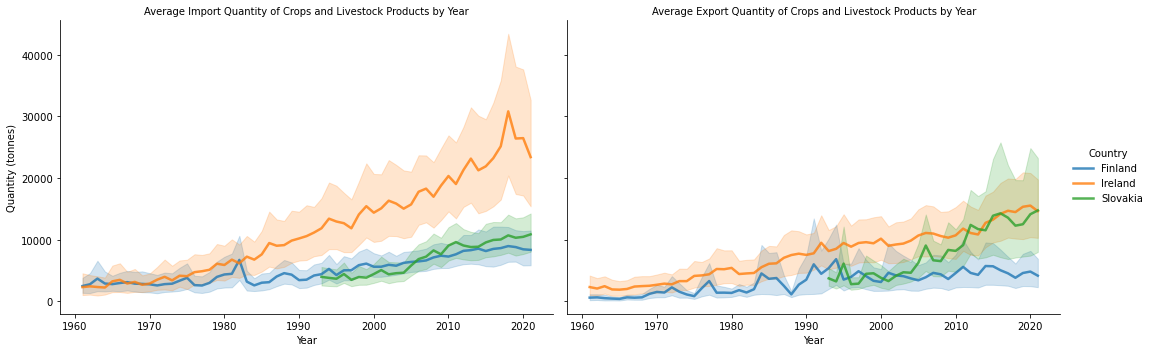

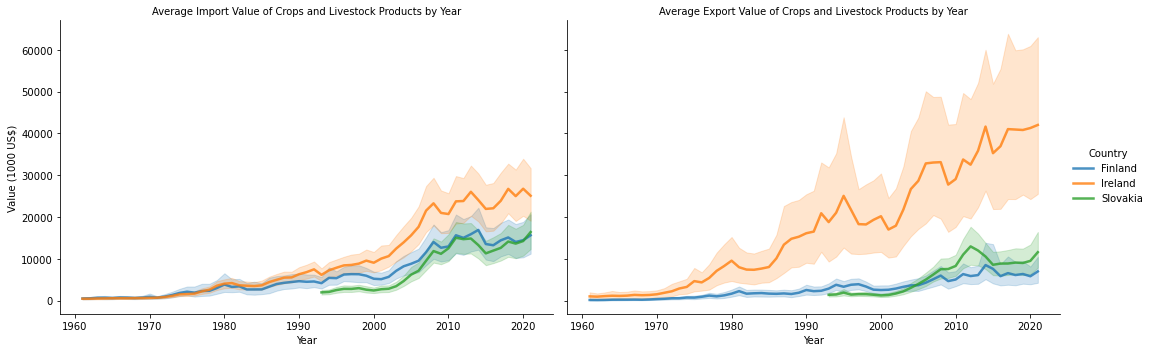

In [25]:
# adding the datasets into a list to facilitate graph generation
datasets = [im_ex_qtt_data, im_ex_val_data]

# graph file names
graph_fnames = [GRAPH_IMP_EXP_QTT, GRAPH_IMP_EXP_VAL]

# y labels to be displayed
y_labels = ['Quantity (tonnes)', 'Value (1000 US$)']

# counter to access the arrays
idx = 0

# create the graph for each dataset (quantity and value)
for data in datasets:
    # create the grid to display the import and export data
    im_exp_grid = sns.FacetGrid(data, col='Element', hue='Area', height=5, aspect=1.5)

    # map the above form facetgrid with some attributes
    im_exp_grid.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

    # adding legend
    im_exp_grid.add_legend(title='Country')
    
    # setting labels and titles
    im_exp_grid.set_xlabels('Year')
    im_exp_grid.set_ylabels(y_labels[idx])
    im_exp_grid.set_titles('Average {col_name} of Crops and Livestock Products by Year')

    # save graph as an image
    im_exp_grid.savefig(join(IMAGES_FOLDER, graph_fnames[idx]), format='png')
    
    # next iteration
    idx+=1

The average data from both datasets were retrieved and stored in the output folder to be used by other notebooks.

In [26]:
# getting the average quantity of tonnes of import/export a year
imp_ex_qtt_avg = im_ex_qtt_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True).astype({'Year':'int'})

# getting the average value in US$ of import/export a year
imp_ex_val_avg = im_ex_val_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True).astype({'Year':'int'})

# union both datasets
imp_exp_avg_dfs = [imp_ex_val_avg, imp_ex_qtt_avg]
imp_exp_avg_union = pd.concat(imp_exp_avg_dfs)

# getting import only data
imp_df = imp_exp_avg_union[(imp_exp_avg_union['Element'].str.contains('Import'))]

# getting export only data
exp_df = imp_exp_avg_union[(imp_exp_avg_union['Element'].str.contains('Export'))]

# creating a csv file in the output folder for the average import dataset
imp_df.to_csv(join(DATA_PREP_FOLDER, IMP_DATASET_AVG), index=False)

# creating a csv file in the output folder for the average export dataset
exp_df.to_csv(join(DATA_PREP_FOLDER, EXP_DATASET_AVG), index=False)

In this step, the top 10 import products in Ireland in terms of quantity in tonnes were retrieved.

The idea is to use this data in the Dashboard to create an interactive graph to compare the import data among the countries using Altair module.

The reason for limitting the data was that Altair lib can't handle more than 5k rows. The limitation was also to facilitate the data reading.

In [27]:
# getting import data only (quantity and value)
import_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity']
import_val_data = im_ex_val_data[im_ex_val_data['Element'] == 'Import Value']

# getting the top 10 import items in terms of quantity in Ireland
top_10_items_ire = import_qtt_data[(import_qtt_data['Area'] == 'Ireland')].groupby(by='Item', as_index=False).mean().sort_values(by=['Value'], ascending=False, ignore_index=True).head(10)
top_10_items_ire = list(top_10_items_ire['Item'].unique())

print('Top 10 most imported products in Ireland (quantity):')
top_10_items_ire

Top 10 most imported products in Ireland (quantity):


['Maize (corn)',
 'Wheat',
 'Cake of  soya beans',
 'Food wastes',
 'Molasses',
 'Raw milk of cattle',
 'Brewing or distilling dregs and waste',
 'Other non-alcoholic caloric beverages',
 'Bran of wheat',
 'Gluten feed and meal']

After getting the top 10 list above, the dataset was filtered to get only the import data about these products for all coutries.

This way, the countries data can be compared to Ireland.

In [30]:
# getting the IMPORT quantity data on the top 10 items
top_10_items_data_qtt = import_qtt_data[import_qtt_data['Item'].isin(top_10_items_ire)]
top_10_items_data_qtt = top_10_items_data_qtt.sort_values(by=['Value'], ascending=False, ignore_index=True)
top_10_items_data_qtt.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2018,2018,tonnes,1601643.39,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2019,2019,tonnes,1539355.99,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2020,2020,tonnes,1313413.75,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2021,2021,tonnes,1219959.29,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2017,2017,tonnes,1119412.15,A,Official figure


In [31]:
# getting the IMPORT value data on the top 10 items
top_10_items_data_val = import_val_data[import_val_data['Item'].isin(top_10_items_ire)]
top_10_items_data_val = top_10_items_data_val.sort_values(by=['Value'], ascending=False, ignore_index=True)
top_10_items_data_val.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2021,2021,1000 US$,340205.0,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2008,2008,1000 US$,338670.0,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2021,2021,1000 US$,328511.0,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2018,2018,1000 US$,322647.0,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5622,Import Value,39170.01,Food wastes,2018,2018,1000 US$,320887.0,A,Official figure


These datasets were also stored in the output folder to be used by other notebooks. 

More specifically, this data is consumed by the DataPrepVisDashboard, which generates an interactive graph with this dataset.

In [32]:
# creating a csv file in the output folder for the top 10 items quantity dataset
top_10_items_data_val.to_csv(join(DATA_PREP_FOLDER, IMP_DATASET_TOP10_VAL), index=False)

# creating a csv file in the output folder for the top 10 items value dataset
top_10_items_data_qtt.to_csv(join(DATA_PREP_FOLDER, IMP_DATASET_TOP10_QTT), index=False)

The main reason to plot these graphs were to provide a visual idea about the behaviour of the import and export data in the countries.

The interactive graph implemented in the dashboard on the top 10 import products also helps to explain the data in a more granular level.

It also helps to explain the results discussed in the Statistics Jupyter notebook.

## 5. Food Price Inflation

In this section, the agriculture dataset on food price inflation was cleand and prepared for the analysis performed in the Statistics and ML Jupyter notebooks.

This dataset provides the food price inflation percent of EU countries over the years.

In [33]:
# showing raw dataset
dataset = pd.read_csv(join(DATASETS_FOLDER, FOOD_INF_DATASET), encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description,Note
0,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7001,January,%,3.900862,E,Estimated value,NaN
1,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7002,February,%,2.525304,E,Estimated value,NaN
2,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7003,March,%,2.998384,E,Estimated value,NaN
3,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7004,April,%,2.810568,E,Estimated value,NaN
4,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7005,May,%,4.679704,E,Estimated value,NaN


In this step a summary of the dataset is displayed, which shows a null column that was removed.

In [34]:
# showing a summary of the dataset
dataset.describe()

,Area Code (M49),Year Code,Year,Item Code,Months Code,Value,Note
count,783.000000,783.000000,783.000000,783.0,783.000000,783.000000,0.0
mean,440.333333,2011.379310,2011.379310,23014.0,7006.448276,1.793597,NaN
std,192.848091,6.283411,6.283411,0.0,3.438844,3.791925,NaN
min,246.000000,2001.000000,2001.000000,23014.0,7001.000000,-8.216785,NaN
25%,246.000000,2006.000000,2006.000000,23014.0,7003.000000,-0.764112,NaN
50%,372.000000,2011.000000,2011.000000,23014.0,7006.000000,1.376673,NaN
75%,703.000000,2017.000000,2017.000000,23014.0,7009.000000,4.179901,NaN
max,703.000000,2022.000000,2022.000000,23014.0,7012.000000,23.280147,NaN


In [35]:
# remove null column from dataset
dataset = dataset.drop(['Note'], axis=1)

This dataset was also stored in the output folder to be used by other notebooks.

In [36]:
# creating a csv file in the output folder for the food inflation dataset
dataset.to_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET), index=False)

The graph below shows the summarized food price inflation per country by year.

This way, it was possible to visualize the differences between the countries over the years, which helped to explain the results of the analysis in the Statistics Jupyter notebook.

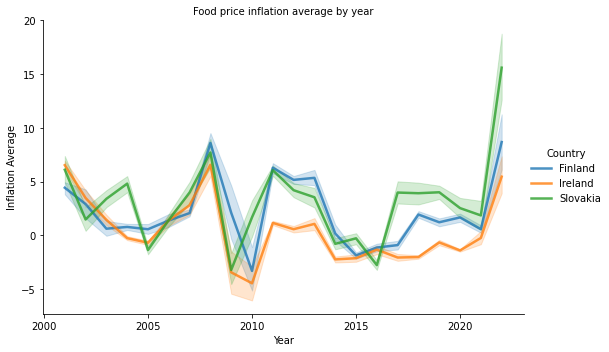

In [37]:
# create the grid to display the import and export data
food_inf_grid = sns.FacetGrid(dataset, col='Item', hue='Area', height=5, aspect=1.5)

# map the above form facetgrid with some attributes
food_inf_grid.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

# adding legend
food_inf_grid.add_legend(title='Country')

# setting labels and titles
food_inf_grid.set_xlabels('Year')
food_inf_grid.set_ylabels('Inflation Average')
food_inf_grid.set_titles('{col_name} average by year')

# save graph as an image
food_inf_grid.savefig(join(IMAGES_FOLDER, GRAPH_FOOD_PRICE_INF), format='png')

The food inflation average was also calculated, since it is used by other notebooks.

In [38]:
# group inflation by year to get consolidated data
food_inf_avg = dataset.groupby(by=['Year', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

This dataset was stored in the output folder to be used by other notebooks.

In [39]:
# creating a csv file in the output folder for the food inflation average dataset
food_inf_avg.to_csv(join(DATA_PREP_FOLDER, FOOD_INF_DATASET_AVG), index=False)

## 6. Twitter Dataset

In this section, it was implemented the logic to retrieve recent tweets using the Twitter API.

The idea was to collect tweets about agriculture so they could be used for sentiment analysis and classification.

For this part, 3 Python helper modules were implemented under jupyter/modules folder:

- TextProcessor: Which has the methods to process the text using the approaches used in this project.
- TwitterAPI: Which contains the logic to access Twitter platform and retrieve the recent tweets based on the search criteria.
- JsonHelper: It was used to convert dictionaries into JSON format.

The reason to separate these modules from the Jupyter notebooks was to keep the code organised and to follow the best programming practices with regards to reuse and code modularization.

The output of this data preparation was consumed by the ML Jupyter notebook.

### 6.1 Twitter API

User should have an account on <a href="https://developer.twitter.com/">Twitter's Developer Portal</a> to obtain their own access keys and tokens to be able to run this part and get a fresh recent tweets dataset.

- The Twitter's developer account access level required to run this notebook is 'Essential'.

- There should exist a file called .twitter_env in the machine's home directory with the following API user keys:
    ```
    API_KEY=***
    API_KEY_SECRET=***
    BEARER_TOKEN=***
    ```

The tweets collected are stored in the datasets/tweets-online folder.

<b>The next code block can be skipped if user does not have the access keys, as the tweets were previously collected for the project.</b>

In [45]:
# SKIP THIS CODE IF NO ACCESS KEYS WAS PROVIDED

# getting an instance of the twitter api
twitter_api = TwitterApi(get_env_map())

# defining the query parameters
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    'max_results': '100'
}

# retrieving tweets according to the query
tweets_list = twitter_api.search_tweets(query_params)

# processing retrieved data using text processing
tweets_df = process_tweets(tweets_list)

# storing the processed data in the datasets/tweets-online folder
tweets_df.to_csv(get_collected_twitter_file_path())

# show the tweets collected
tweets_df.head()

199 tweets retrieved!


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,# Investors await eurozone inflation data and ...,negative,investors await eurozone inflation data and u...,negative,investors await eurozone inflation data us job...,negative,investor await eurozon inflat data us job figu...,negative,investors await eurozone inflation data us job...,negative
1,Citi Says Central and Eastern Europe Inflation...,negative,citi says central and eastern europe inflation...,negative,citi says central eastern europe inflation rem...,negative,citi say central eastern europ inflat remain s...,negative,citi says central eastern europe inflation rem...,negative
2,5.2% core inflation in Europe means the ECB wi...,negative,core inflation in europe means the ecb wi...,negative,core inflation europe means ecb push harder hi...,negative,core inflat europ mean ecb push harder hike eu...,negative,core inflation europe means ecb push hard hike...,negative
3,Who will benefit from such a huge correction o...,positive,who will benefit from such a huge correction o...,positive,benefit huge correction naturalgas inflation c...,positive,benefit huge correct naturalga inflat come eur...,positive,benefit huge correction naturalgas inflation c...,positive
4,Inflation drops sharply in Europe but some pri...,negative,inflation drops sharply in europe but some pri...,negative,inflation drops sharply europe prices still ri...,negative,inflat drop sharpli europ price still rise,neutral,inflation drops sharply europe prices still ri...,negative


Since the recent tweets can change over time, the analysis was performed on a previously collected dataset available in the ./datasets/tapi-agri-tweets.csv file.

This way, if the user wants to use a fresh tweets list collected from the previous step, they should do the following:

1. Copy the csv just created from the ./datasets/tweets-online folder
2. Paste it into the ./datasets folder
3. Remove the old tapi-agri-tweets.csv file or add a .bkp suffix to keep it
4. Rename the new one to 'tapi-agri-tweets.csv'

In [47]:
# using tweets dataset from tapi-agri-tweets.csv file
tweets_df = pd.read_csv(join(DATASETS_FOLDER, TWEETS_DATASET))

# showing the tweets
tweets_df.head()

,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive,british public were treated like mugs lied to...,negative
1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive,eu economies set to contract in financi...,positive
2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive,big big good news for all europe and usa in su...,negative
3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive,the measures coupled with an agreement negot...,positive
4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive,it was due to the problems of europe covid ...,positive


### 6.2 Text Processing for Sentiment Analysis

Since this dataset was used for sentiment analysis, the following operations were performed as part of EDA:

1. Get the raw tweets using the API

2. Clean the tweets and save the different outputs using the following strategies:
    1. Removal of special characters, links and images (tweet_str)
    2. Application of step A + Removal of stop words (tweet_clr)
    3. Application of step B + Lemmatizer technique (tweet_lm)
    4. Application of step B + Stemmer techinique (tweet_st)

3. Extract the sentiment from each version of the tweets

4. Save data in a dataframe.

Each tweet version had its own sentiment calculated, because it was observed that the sentiment algorithm provides different results for each of them.

The strategies applied to process the tweets were used in the context of the ML analysis that were performed and discussed in the ML notebook.

This dataset was stored in the output folder to be used by other notebooks.

In [48]:
# creating a csv file in the output folder for the tweets dataset
tweets_df.to_csv(join(DATA_PREP_FOLDER, TWEETS_DATASET), index=False)

### 6.3 Tweets Dataset Visualization

In order to visualize this dataset, it was prepared a frequency graph to show the most common words.

Frequency graphs and word clouds are common ways to visualize text datasets, so it is possible to have an idea of its main content.

For this purpose it was used a tokenizer algorithm to generate tags from all the tweets after the cleanning stage.

The frequency was the same if Stemmer or Lemmatizer techniques were applied, so the following graph only shows the frequency of the cleaned tweet data.

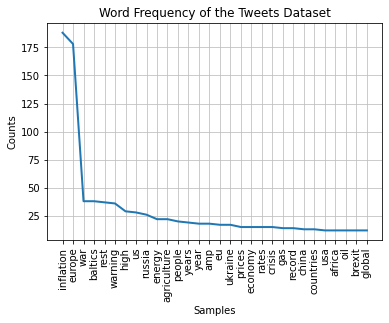

<AxesSubplot:title={'center':'Word Frequency of the Tweets Dataset'}, xlabel='Samples', ylabel='Counts'>

In [50]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
g_plot = fdist.plot(30, cumulative=False, title='Word Frequency of the Tweets Dataset')

# saving graph as an image
fig = g_plot.get_figure()
fig.savefig(join(IMAGES_FOLDER, GRAPH_WORD_FREQ), format='png')

# showing the image
g_plot

Another way to visualize text datasets is by using word clouds which facilitates the observation of the most frequent words.

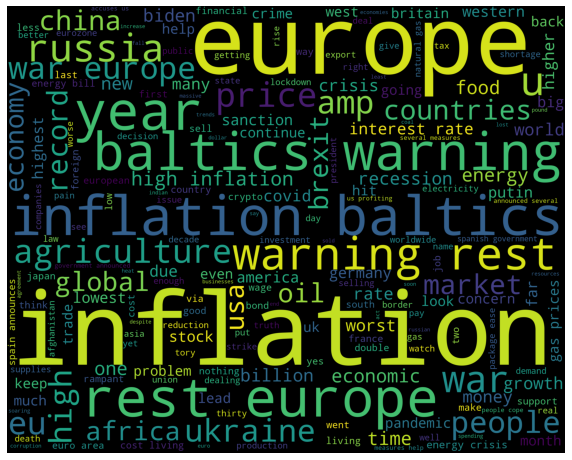

In [51]:
wordcloud_draw(tweets_df['tweet_clr'])

One of the query words used to search for the agriculture tweets were 'inflation'.

So, based on the frequency count and word cloud above, 'inflation' appeared more than the others tokens.

Moreover, it is observed that some Twitter users are relating agriculture with the Russian war on Ukraine.

## 7. Interactive Dashboard

The dashboard solution used was <a href="https://voila.readthedocs.io/en/stable/index.html">Voila</a>, which is a tool that allows users to convert Jupyter notebooks into interactive dashboards. 

The outcome of this tool is a web page that is generated out of the Jupyter file, which can run locally or be deployed to a web server for broader audience.

Every Jupyter notebook accompanying this project can be converted into a dashboard using Voila tool using the command:

```
voila DataPrepVisDashboard.ipynb
```

For demonstration purposes, a separete light Jupyter notebook called DataPrepVisDashboard was created with the graphs of the this EDA process. 

As an extra step, an interactive graph was implemented for the dashboard using Altair.

The already extracted HTML dashboard can be accessed in the dashboard folder.